---
layout: default
title: "SVM - Large Margin Classification"
categories: SVM
permalink: /ML20/
order: 20
comments: true
---

In [39]:
%pylab --no-import-all inline
import sympy
from matplotlib.patches import ArrowStyle
matplotlib.rcParams['text.usetex'] = False
plt.rcParams["mathtext.fontset"] = "cm"

Populating the interactive namespace from numpy and matplotlib


# Support Vector Machines
At this point we have seen a number of learning algorithm. While it is true to a certain degree that different learning algorithms have similar performances and that the amount and quality of data is fundamental, we need to cover another class of learning algorithm that are often used in industry and academia, the **Support Vector Machines** (SVM). These algorithms can sometimes give a cleaner and more powerful way of learning complex non-linear functions.

## Optimization objective
Let's see how we can get to a support vector machine from a logistic regression algorithm.

In a classic logistic regression algorithm we have our hypothesis based on the sigmoid activation function

$$
h_\theta(x) = \frac{1}{1+e^{-\theta^Tx}}
$$

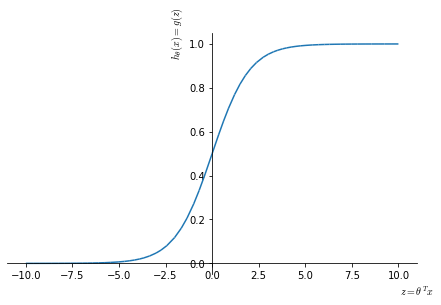

In [25]:
x = sympy.symbols('x')
logistic = lambda z: 1/(1+(np.e**(-z)))
p = sympy.plot(logistic(x), xlabel='$z = \\theta^Tx$', ylabel='$h_\\theta(x) = g(z)$')

In logistic regression:

* for $y=1$ we would like $h_\theta(x)\approx 1 \leftarrow \theta^T \gg 0$ 
* for $y=0$ we would like $h_\theta(x)\approx 0 \leftarrow \theta^T \ll 0$

Each examples contributes to the total cost computed by the cost function by the term:

$$
-y \log (h_\theta(x)) - (1-y) \cdot \log (1-h_\theta(x))
$$

That, when replacing the $h_\theta(x)$ term, becomes:

$$
\begin{equation}
\color{royalblue}{-y\log \left(\frac{1}{1+e^{-\theta^Tx}}\right)} - \color{darkgreen}{(1-y) \cdot \log \left(1-\frac{1}{1+e^{-\theta^Tx}} \right)}
\end{equation}
\label{eq:logcost} \tag{1}
$$

When $y=1$, the contribution to the cost function is given by the left factor in $\eqref{eq:logcost}$, a single example will have a very small contribution to the cost function for large values of $z$ (<a href="#costterms">Figure below</a>, panel A, blue line). To build a SVM, we will build a cost function such that its behavior will be like that of the orange line in panel A of <a href="#costterms">the Figure below</a>. As we will see later, this make the SVM behave similarly to logistic regression while giving a computational advantage by simplifying the optimization problem.

When $y=0$, the SVM will be very similar witha semi-step behavior at 1 in reversed direction (<a href="#costterms">Figure below</a>, panel B, orange line)

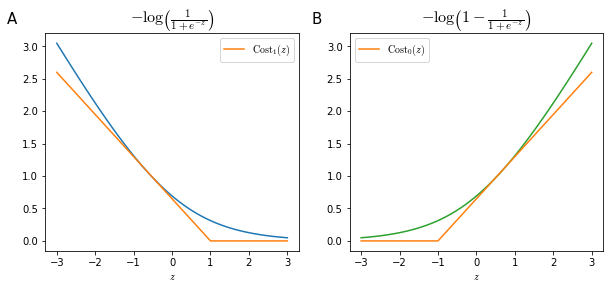

In [31]:
x = np.linspace(-3, 3)
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(x, -np.log(logistic(x)))
ax1.set_title(r'$-\log \left(\frac{1}{1+e^{-z}} \right)$', fontsize=16)
ax1.plot([-3, 1, 3], [2.6, 0, 0], c='C1', label='$\\mathrm{Cost}_1(z)$')
ax2.plot(x, -np.log(1-logistic(x)), c='C2')
ax2.set_title(r'$-\log \left( 1-\frac{1}{1+e^{-z}}\right)$', fontsize=16)
ax2.plot([-3, -1, 3], [0, 0, 2.6], c='C1', label='$\\mathrm{Cost}_0(z)$')

for ax, label in zip([ax1, ax2], ["A", "B"]):
    ax.legend()
    ax.set_xlabel('$z$')
    ax.text(-0.15, 1.1, label, transform=ax.transAxes,
            fontsize=15, va='top')

<i id="costterms">Cost term for a single example in logistic regression as a function of $z$ in the cases of $y=1$ (A, blue) and $y=0$ (B); and their versions in an SVM (A, B, orange lines).</i>

So, where the optimization problem in logistic regression is:

$$
\min_\theta\frac{1}{m} \sum_{i=1}^m \left[y^{(i)} \left(- \log h_\theta(x^{(i)})\right) +(1-y^{(i)}) \cdot \left(-\log (1-h_\theta(x^{(i)}))\right) \right] + \frac{\lambda}{2m} \sum_{j=0}^n\theta_j^2
$$

By just substituting the $Cost_{0/1}$ terms, the optimization problem for an SVM would be:

$$
\begin{equation}
\min_\theta \color{red} {\frac{1}{m}} \color{black}{\sum_{i=1}^m \left[ y^{(i)} \text{ Cost}_1(\theta^Tx^{(i)}) + (1-y^{(i)}) \text{ Cost}_0(\theta^Tx^{(i)}) \right] +} \frac{ \color{magenta}{ \lambda}}{2 \color{red}{m}} \sum_{j=0}^n\theta_j^2
\end{equation}
$$

However we are going to slightly reparametrize it:

1. First we are going to get rid for the $\color{red}{\frac{1}{m}}$ term, as for the SVM the convention doesn't include this term. Since this term is a constant, we should end up with the same optimal value for $\theta$ if we  either include or remove it.
2. Second, we want to remove the regularization parameter $\color{magenta}{\lambda}$ in favor of another parameter that we can call $\color{magenta}{C}$. While in logistic regression we express the optimization problem in the form $A+\lambda B$, in SVM the form is $CA+B$, where $C$ can be thought as (but is not equivalent to) $\frac{1}{\lambda}$, in the sense that reducing $C$ has the effect of scaling down $A$ with respect to $B$.

With these two modifications we can now write the conventional form of the optimization problem for an SVM:

$$
\begin{equation}
\min_\theta C  \sum_{i=1}^m \left[y^{(i)} \text{ Cost}_1(\theta^Tx^{(i)}) + (1-y^{(i)}) \text{ Cost}_0(\theta^Tx^{(i)}) \right] + \frac{1}{2} \sum_{j=0}^n\theta_j^2
\end{equation}
\label{eq:svmcost} \tag{2}
$$

## Large Margin Classification
Sometimes SVMs are referred to as large margin classifiers. In this section we will see why and we will introduce the hypothesis representation of SVMs.

### Large margin classification - intuition
By looking at <a href='#svmcost'>the figure below</a>, we can see that if we want to minimize the cost of a training example, we need to have:

* If we have $y=1$ (panel A), then to have $\text{Cost}_1(z)=0$, we need to have $z \equiv (\theta^Tx) \geq 1$ and not just $\geq 0$
* If we have $y=0$ (panel B), then to have $\text{Cost}_1(z)=0$, we need to have $z \equiv (\theta^Tx) \leq -1$ and not just $< 0$

This builds in an extra safety **margin** for correct classification in SVMs.

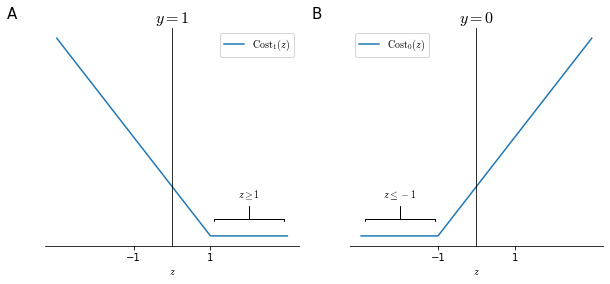

In [53]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 4))
ax1.set_title(r'$y=1$', fontsize=16)
ax1.plot([-3, 1, 3], [2.6, 0, 0], label=r'$\mathrm{Cost}_1(z)$')
ax2.set_title(r'$y=0$', fontsize=16)
ax2.plot([-3, -1, 3], [0, 0, 2.6], label=r'$\mathrm{Cost}_0(z)$')
ax1.annotate(r'$z \geq 1$',
             xy=(2, 0.2), xytext=(2, .5), 
             horizontalalignment='center',
             arrowprops = {'arrowstyle': ArrowStyle('-[', widthB=3.5, lengthB=0.2, angleB=None),
                           'connectionstyle': "arc,angleA=0,angleB=0,armA=0,armB=0,rad=0"})
ax2.annotate(r'$z \leq -1$',
             xy=(-2, 0.2), xytext=(-2, .5), 
             horizontalalignment='center',
             arrowprops = {'arrowstyle': ArrowStyle('-[', widthB=3.5, lengthB=0.2, angleB=None),
                           'connectionstyle': "arc,angleA=0,angleB=0,armA=0,armB=0,rad=0"})

for ax, label in zip([ax1, ax2], ["A", "B"]):
    ax.spines['left'].set_position('center')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.set_yticks([])
    ax.legend()
    ax.set_xticks([-1, 1])
    ax.set_xlabel('$z$')
    ax.text(-0.15, 1.1, label, transform=ax.transAxes,
            fontsize=15, va='top')

<i id="svmcost">Cost of a single example in a SVM as a function of $z \equiv \theta^Tx$, for the case of $y=1$ (A) and $y=0$ (B).</i>

Consider a case where we set the regularization parameter $C$ to a very large value. This will allow us to see a simplified and more intuitive version of the working of an SVM, which however does not reflect their entire complexity. When $C$ is very large then the optimization process declared in $\eqref{eq:svmcost}$ will chose the values so that the sum of the cost of all examples is $=0$

$$
\min_\theta \overbrace{C}^{\gg 0} \underbrace{\sum_{i=1}^m \left[y^{(i)} \text{ Cost}_1(\theta^Tx^{(i)}) + (1-y^{(i)}) \text{ Cost}_0(\theta^Tx^{(i)}) \right]}_{=0} + \frac{1}{2} \sum_{j=0}^n\theta_j^2
$$

So our optimization problem becomes 

$$
\begin{align}
&\min_\theta C \cdot 0 + \frac{1}{2} \sum_{j=1}^n \theta_j^2 \\
&\mathrm{s.t. } 
\begin {cases}
\theta^Tx^{(i)}\geq & 1  & \mathrm{if} \; y^{(i)}=1\\
\theta^Tx^{(i)}\leq &-1 & \mathrm{if} \; y^{(i)}=0\\
\end{cases}
\end{align}
$$

When solving this opimization problem you obtain a very interesting **decision boundary**. Let's take a training set like that in <a href="#decbound">the Figure below</a>. This data is linearly separable and multiple decision boundary would separate positive and negative examples perfectly (panel A). But none of those, while minimizing the cost function, look like sensible choices, since the data hints at a pattern that is not picked up by those decision boundaries.

An SVM instead would set its decision boundary as in panel B (black line). In order to achieve that decision boundary, the SVM tries to maximize the distance between the closest points to the decision boundary itself: it tries to maximize its **margins**.

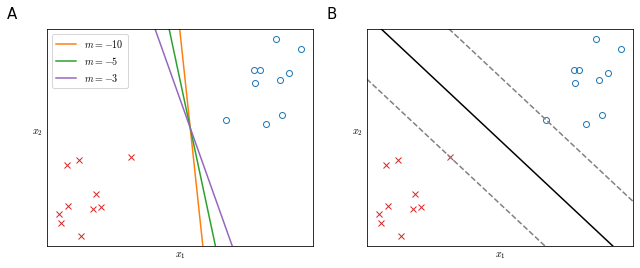

In [209]:
jitter = np.random.rand(2, 10)+.1
xy = np.random.rand(2, 10)
xy1 = xy*.1-jitter
xy2 = xy*.1+jitter

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10.5, 4))

for ax, label in zip([ax1, ax2], ["A", "B"]):
    ax.plot(*xy1, ls='none', marker='x', c='C3')
    ax.plot(*xy2, ls='none', marker='o', c='C0', markerfacecolor='none');
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$', rotation=0, ha='right')
    ax.text(-0.15, 1.1, label, transform=ax.transAxes,
            fontsize=15, va='top')

for m, c in zip([-10, -5, -3], ['C1', 'C2', 'C4']):
    ax1.axline((sum(ax1.get_xlim()), sum(ax1.get_ylim())), slope=m, c=c, 
              label='$m={{{}}}$'.format(m))
ax1.legend()

maxxy1 = xy1[:, np.argmax(np.sum(xy1, axis=0))]
ax2.axline(maxxy1, slope=-1, ls='--', c='grey')
minxy2 = xy2[:, np.argmin(np.sum(xy2, axis=0))]
ax2.axline(minxy2, slope=-1, ls='--', c='grey')
ax2.axline((maxxy1+minxy2)/2, slope=-1, c='k');               

<i id="decbound">Linear decision boundaries obtained by logistic regression with equivalent cost (A). Linear decision boundary obtained through large margin classification (B).</i>

The SVM tries to separate the data with the largest margin possible, for this reason the SVM is sometimes called large margin classifier.

Large margin classifiers are not very robust to outliers and to be fair, SVMs are a bit more sophisticated and robust than the simple concept of large margin classifier explained above. SVM behaves like large margin classifier **only** when $C$ is very large ($\equiv \lambda$ is very small, since $C \approx \frac{1}{\lambda}$), in other words when there is no regularization. However this is a useful way to convey an intuition of how SVMs work.

### Large margin classification - mathematics